In [ ]:
import glob
import PIL.Image as Image
import pandas as pd
import pickle
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error, euclidean_distances
from sklearn.model_selection import train_test_split
from keras import Sequential, Input, Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, MaxPooling2D, UpSampling2D
import keras.backend as K
import keras
import argparse

print('imported')

Using TensorFlow backend.


imported


In [ ]:
with open('data_normal','rb') as f:
    data = pickle.load(f)
with open('data_anomalies','rb') as f:
    anomalies = pickle.load(f)


data_labels = np.ones(len(data))
y_anom = -1 * np.ones(len(anomalies))

x_train, x_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)

x_train = np.asarray(x_train)
x_train = x_train.reshape((x_train.shape[0], 80, 64, 1))
x_test = np.asarray(x_test)
x_test = x_test.reshape((x_test.shape[0], 80, 64, 1))
x_valid = np.asarray(x_valid)
x_valid = x_valid.reshape((x_valid.shape[0], 80, 64, 1))
x_anom = np.asarray(anomalies)
x_anom = x_anom.reshape((x_anom.shape[0], 80, 64, 1))


print('x_train', x_train.shape, y_train.shape)
print('x_valid', x_valid.shape, y_valid.shape)
print('x_test', x_test.shape, y_test.shape)
print('x_anom', x_anom.shape, y_anom.shape)

x_train (1958, 80, 64, 1) (1958,)
x_valid (218, 80, 64, 1) (218,)
x_test (385, 80, 64, 1) (385,)
x_anom (3405, 80, 64, 1) (3405,)


Autoencoder Conv
--------

In [ ]:
# building encoder model
inputShape = (80, 64, 1)

input_img = Input(shape=inputShape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoderC = Model(input_img, decoded)
autoencoderC.compile(optimizer='adam', loss='mse')

autoencoderC.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 8, 8)          0   

Train on 1958 samples, validate on 218 samples
Epoch 1/20
1958/1958 [==============================] - 8s 4ms/step - loss: 0.0764 - val_loss: 0.0187
Epoch 2/20
1958/1958 [==============================] - 1s 623us/step - loss: 0.0145 - val_loss: 0.0114
Epoch 3/20
1958/1958 [==============================] - 1s 618us/step - loss: 0.0110 - val_loss: 0.0096
Epoch 4/20
1958/1958 [==============================] - 1s 625us/step - loss: 0.0096 - val_loss: 0.0086
Epoch 5/20
1958/1958 [==============================] - 1s 625us/step - loss: 0.0087 - val_loss: 0.0082
Epoch 6/20
1958/1958 [==============================] - 1s 617us/step - loss: 0.0081 - val_loss: 0.0073
Epoch 7/20
1958/1958 [==============================] - 1s 620us/step - loss: 0.0075 - val_loss: 0.0070
Epoch 8/20
1958/1958 [==============================] - 1s 617us/step - loss: 0.0071 - val_loss: 0.0066
Epoch 9/20
1958/1958 [==============================] - 1s 624us/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/20
1958/19

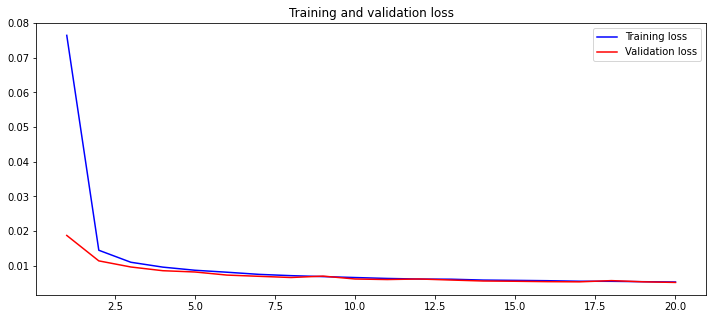

In [ ]:
# fitting model
H = autoencoderC.fit( x_train, x_train, validation_data=(x_valid, x_valid), epochs=20, batch_size=32, verbose=1)

loss = H.history['loss']
val_loss = H.history['val_loss']
x = range(1, len(loss) + 1)
plt.figure(figsize=(12, 5))
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# predict and show results
testing_setC = np.concatenate((x_test, x_anom), axis=0)
testing_tagsC = np.concatenate((y_test, y_anom), axis=0)

print(testing_setC.shape)

predictionsC = autoencoderC.predict(testing_setC)
print('trained', predictionsC.shape)
print('testing', testing_setC.shape)

(3790, 80, 64, 1)
trained (3790, 80, 64, 1)
testing (3790, 80, 64, 1)


In [ ]:
mse = []
rmse = []
ed = []
for original, decoded in zip(testing_setC, predictionsC):
    mse.append( mean_squared_error(original.flatten(),decoded.flatten() ) )
    rmse.append( np.sqrt( mean_squared_error(original.flatten(),decoded.flatten() ) ) )
    ed.append( np.sqrt( np.power( np.sum( original.flatten() - decoded.flatten() ) ,2) ) )
    
    
mse = np.array(mse)
rmse = np.array(rmse)
ed = np.array(ed)

tpr_mse_1, fpr_mse_1, thresholds_mse_1 = roc_curve(testing_tagsC, mse, pos_label=1)
tpr_rmse_1, fpr_rmse_1, thresholds_rmse_1 = roc_curve(testing_tagsC, rmse, pos_label=1)
tpr_ed_1, fpr_ed_1, thresholds_ed_1 = roc_curve(testing_tagsC, ed, pos_label=1)

print('results ready')

results ready


Autoencoder Dense
----------

In [ ]:
dim = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
input_img = Input(shape=(dim, ))  # adapt this if using `channels_first` image data format

encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(dim, activation='sigmoid')(decoded)

autoencoderD = Model(input_img, decoded)
autoencoderD.compile(optimizer='adam', loss='mse')

autoencoderD.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5120)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               655488    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 5120)              6604

Train on 1958 samples, validate on 218 samples
Epoch 1/20
1958/1958 [==============================] - 1s 327us/step - loss: 0.0463 - val_loss: 0.0258
Epoch 2/20
1958/1958 [==============================] - 0s 234us/step - loss: 0.0229 - val_loss: 0.0173
Epoch 3/20
1958/1958 [==============================] - 0s 230us/step - loss: 0.0168 - val_loss: 0.0155
Epoch 4/20
1958/1958 [==============================] - 0s 239us/step - loss: 0.0152 - val_loss: 0.0143
Epoch 5/20
1958/1958 [==============================] - 0s 226us/step - loss: 0.0145 - val_loss: 0.0134
Epoch 6/20
1958/1958 [==============================] - 0s 243us/step - loss: 0.0133 - val_loss: 0.0125
Epoch 7/20
1958/1958 [==============================] - 0s 231us/step - loss: 0.0128 - val_loss: 0.0122
Epoch 8/20
1958/1958 [==============================] - 0s 226us/step - loss: 0.0126 - val_loss: 0.0120
Epoch 9/20
1958/1958 [==============================] - 0s 230us/step - loss: 0.0123 - val_loss: 0.0119
Epoch 10/20
1958/

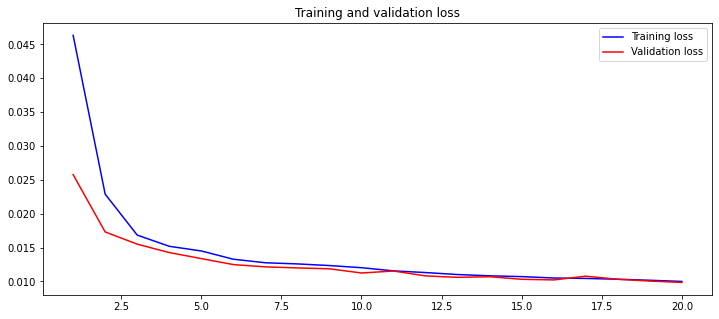

In [ ]:
# fitting model
train = x_train.reshape((x_train.shape[0], x_train.shape[1]* x_train.shape[2]))
valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1]* x_valid.shape[2]))

H = autoencoderD.fit( train, train, validation_data=(valid, valid), epochs=20, batch_size=32, verbose=1, use_multiprocessing=True)

loss = H.history['loss']
val_loss = H.history['val_loss']
x = range(1, len(loss) + 1)
plt.figure(figsize=(12, 5))
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# predict and show results
test = x_test.reshape((x_test.shape[0], x_test.shape[1]* x_test.shape[2]))
anom = x_anom.reshape((x_anom.shape[0], x_anom.shape[1]* x_anom.shape[2]))

testing_setD = np.concatenate((test, anom), axis=0)
testing_tagsD = np.concatenate((y_test, y_anom), axis=0)

print(testing_setD.shape)

predictionsD = autoencoderD.predict(testing_setD)
print('trained', predictionsD.shape)
print('testing', testing_setD.shape)

(3790, 5120)
trained (3790, 5120)
testing (3790, 5120)


In [ ]:
mse = []
rmse = []
ed = []
for original, decoded in zip(testing_setD, predictionsD):
    mse.append( mean_squared_error(original,decoded ) )
    rmse.append( np.sqrt( mean_squared_error(original,decoded ) ) )
    ed.append( np.sqrt( np.power( np.sum( original - decoded ) ,2) ) )
    
    
mse = np.array(mse)
rmse = np.array(rmse)
ed = np.array(ed)

print('results ready')

results ready


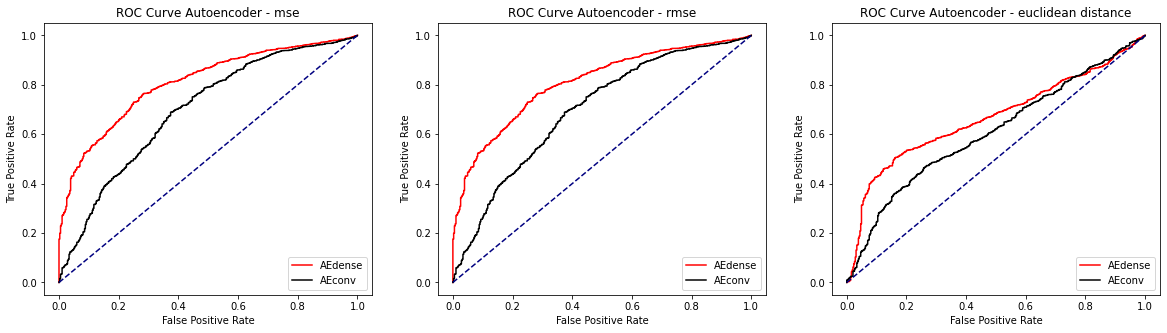

In [ ]:
tpr_mse, fpr_mse, thresholds_mse = roc_curve(testing_tagsD, mse, pos_label=1)
tpr_rmse, fpr_rmse, thresholds_rmse = roc_curve(testing_tagsD, rmse, pos_label=1)
tpr_ed, fpr_ed, thresholds_ed = roc_curve(testing_tagsD, ed, pos_label=1)
 
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(fpr_mse, tpr_mse, color='red', label='AEdense')
plt.plot(fpr_mse_1, tpr_mse_1, color='black', label='AEconv')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - mse')
plt.legend(loc='lower right')
plt.subplot(132)
plt.plot(fpr_rmse, tpr_rmse, color='red', label='AEdense')
plt.plot(fpr_rmse_1, tpr_rmse_1, color='black', label='AEconv')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - rmse')
plt.legend(loc='lower right')
plt.subplot(133)
plt.plot(fpr_ed, tpr_ed, color='red', label='AEdense')
plt.plot(fpr_ed_1, tpr_ed_1, color='black', label='AEconv')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - euclidean distance')
plt.legend(loc='lower right')
plt.show()

La curva di un buon anomaly detector dovrebbe essere quanto più possibile adattata all'angolo in alto a sinistra, più ci si avvicina, meglio lavora.
La curva "bassa" è dovuta principalmente alla confusione, naturale, che si viene a creare nel dataset tra immagini di scarpe casual e sportive che non sono del tutto distinguibili e diverse. Infatti togliendo le scarpe sportive dalle anomalie possiamo osservare come migliora sensibilmente l'accuratezza del detector.

In [ ]:
with open('data_anomalies_without_shoes','rb') as f:
    x_anom = np.array(pickle.load(f))
    
x_anom = x_anom.reshape((x_anom.shape[0], 80, 64,1))
y_anom = np.ones(x_anom.shape[0])*-1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_anom.shape, y_anom.shape)

testing_setC = np.concatenate((x_test, x_anom), axis=0)
testing_setD = np.concatenate( (x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2])), 
                                x_anom.reshape((x_anom.shape[0], x_anom.shape[1]*x_anom.shape[2]))),
                              axis=0 )

testing_tags = np.concatenate((y_test, y_anom), axis=0)

print('testing_setC',testing_setC.shape, testing_tags.shape)
print('testing_setD',testing_setD.shape, testing_tags.shape)

(1958, 80, 64, 1) (1958,)
(385, 80, 64, 1) (385,)
(1573, 80, 64, 1) (1573,)
testing_setC (1958, 80, 64, 1) (1958,)
testing_setD (1958, 5120) (1958,)


In [ ]:
predictions_C = autoencoderC.predict(testing_setC)
predictions_D = autoencoderD.predict(testing_setD)
print('trainedC', predictions_C.shape)
print('trainedD', predictions_D.shape)

trainedC (1958, 80, 64, 1)
trainedD (1958, 5120)


In [ ]:
mse_D = []
mse_C = []
rmse_D = []
rmse_C = []
ed_D = []
ed_C =[]

for original_C, original_D, decoded_C, decoded_D in zip(testing_setC, testing_setD, predictions_C, predictions_D):
    
    mse_D.append( mean_squared_error(original_C.flatten(),decoded_C.flatten() ) )
    rmse_D.append( np.sqrt( mean_squared_error(original_C.flatten(),decoded_C.flatten() ) ) )
    ed_D.append( np.sqrt( np.power( np.sum( original_C.flatten() - decoded_C.flatten() ) ,2) ) )
    
    mse_C.append( mean_squared_error(original_D, decoded_D ) )
    rmse_C.append( np.sqrt( mean_squared_error(original_D, decoded_D ) ) )
    ed_C.append( np.sqrt( np.power( np.sum( original_D - decoded_D ) ,2) ) )
    
mse_C = np.array(mse_C)
rmse_C = np.array(rmse_C)
ed_C = np.array(ed_C)

mse_D = np.array(mse_D)
rmse_D = np.array(rmse_D)
ed_D = np.array(ed_D)

print('results ready')

results ready


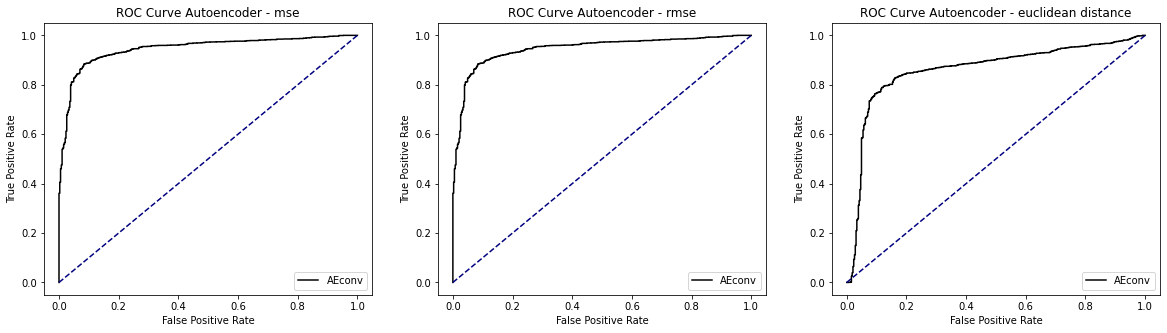

In [ ]:
tpr_mse_C, fpr_mse_C, thresholds_mse = roc_curve(testing_tags, mse_C, pos_label=1)
tpr_rmse_C, fpr_rmse_C, thresholds_rmse = roc_curve(testing_tags, rmse_C, pos_label=1)
tpr_ed_C, fpr_ed_C, thresholds_ed = roc_curve(testing_tags, ed_C, pos_label=1)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(fpr_mse_C, tpr_mse_C, color='black', label='AEconv')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - mse')
plt.legend(loc='lower right')
plt.subplot(132)
plt.plot(fpr_rmse_C, tpr_rmse_C, color='black', label='AEconv')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - rmse')
plt.legend(loc='lower right')
plt.subplot(133)
plt.plot(fpr_ed_C, tpr_ed_C, color='black', label='AEconv')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Autoencoder - euclidean distance')
plt.legend(loc='lower right')
plt.show()

OneClass SVM
------

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print('imported')

imported


In [ ]:
with open('data_normal','rb') as f:
    data = pickle.load(f)
with open('data_anomalies','rb') as f:
    anomalies = pickle.load(f)

data_labels = np.ones(len(data))
y_anom = -1 * np.ones(len(anomalies))

x_train, x_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
x_valid = np.asarray(x_valid)
x_anom = np.asarray(anomalies)

x_train = np.concatenate((x_train,x_valid),axis=0)
x_valid = None

print('x_train', x_train.shape, y_train.shape)
print('x_test', x_test.shape, y_test.shape)
print('x_anom', x_anom.shape, y_anom.shape)

x_train (2176, 5120) (1958,)
x_test (385, 5120) (385,)
x_anom (3405, 5120) (3405,)


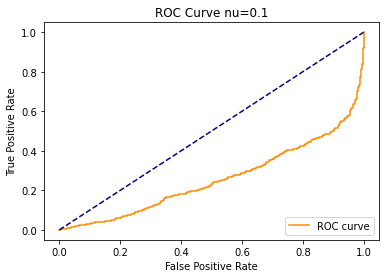

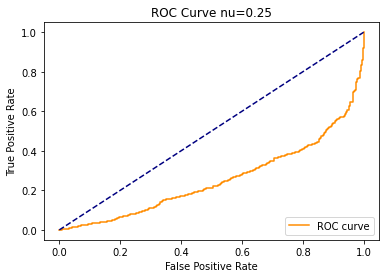

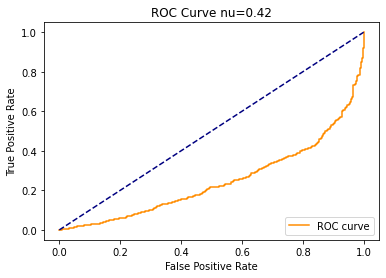

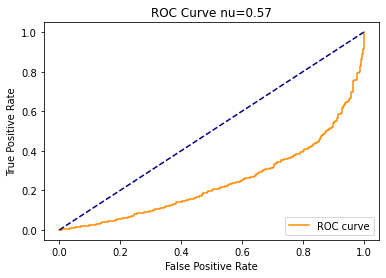

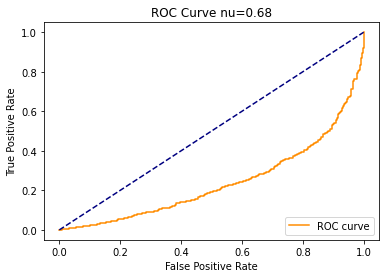

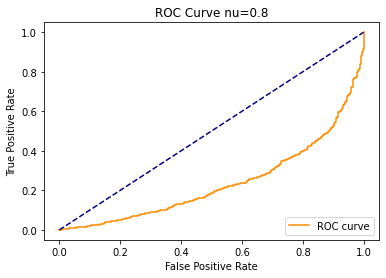

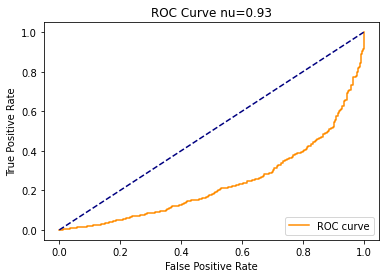

In [ ]:
x_testing = np.concatenate((x_test, x_anom), axis=0)
y_testing = np.concatenate((y_test,y_anom), axis=0)

for nu_val in [0.1, 0.25, 0.42, 0.57, 0.68, 0.8, 0.93]:
    model = OneClassSVM(kernel='rbf', nu=nu_val)
    model.fit(x_train)
    
    tpr, fpr, thresholds = roc_curve(y_testing, model.decision_function(x_testing), pos_label=1)

    plt.figure(10)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve nu=' + str(nu_val))
    plt.legend(loc="lower right")
    plt.show()
    plt.ion()